<a href="https://colab.research.google.com/github/Lisylou-git/JCU_Assessment/blob/main/A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the required packages. This code was run in Google Colab, so required reinstallation each time a new instance was started.

In [1]:
#Importing packages
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.2 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,173 kB]
Get:11 https://ppa.launchpadcontent.net

Import Packages - if running locally, code would start here after initial install

In [2]:
#Import Libraries for scraping
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support.expected_conditions import element_to_be_clickable
from selenium.webdriver.common.keys import Keys
import pandas as pd
from time import sleep
from random import randint

In [94]:
#import libraries for language processing
import numpy as np
import matplotlib.pyplot as plt
from time import time
import seaborn as sns

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#import libraries for machine learning

In [165]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,precision_recall_curve, auc, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

set up chromedriver options

In [3]:
#set up driver options
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

Webcrawling - collect individual book links

In [38]:
#Set up the driver and then run through each of the pages required to scrape the list of book links

#list of URLs - the next button on qbd does not have a unique name so the page is requested as
#a new URL instead of crawling through.
#create function
def get_soupqbd(urls):
  #start driver
  driver = webdriver.Chrome(options=chrome_options)
  wait = WebDriverWait(driver, timeout=45)
  #get the first url
  driver.get(urls[0])
  sleep(10)
  #extract page source and pass into a soup using BeautifulSoup
  sourceqbd = driver.page_source
  soupqbd = BeautifulSoup(sourceqbd)
  driver.quit()
  #run through remaining urls appending the soup from that page to the main one
  for url in urls[1:]:
    driver = webdriver.Chrome(options=chrome_options)
    wait = WebDriverWait(driver, timeout=45)
    driver.get(url)
    sleep(10)
    sourceqbd2 = driver.page_source
    soupqbd2 = BeautifulSoup(sourceqbd)
    soupqbd.append(soupqbd2)
    driver.quit()
  #return one long soup with all pages
  return soupqbd

In [39]:
#creat function to get the list of individual book links from a navigation page soup

def get_links(soup):
  #extract relevant divs
  Links = soup.find_all('div', class_="q2k21ptc")
  #empty list to append to
  links = []
  #pass through each row in the divs
  for row in Links:
    booklink = ''
    #find section of 'a'
    this = row.find('a')
    #try get the href (actual link) otherwise skip
    try:
      booklink = str(this.get('href')).strip()
      links.append(booklink)
      #print(booklink)
    except:
      pass
  #return list of links
  return links

Set up URL lists

In [32]:
#top 2 pages of kids bestsellers
childbesturls = ['https://www.qbd.com.au/childrens/best-sellers',
                 'https://www.qbd.com.au/childrens/best-sellers/2/']

In [33]:
#top 2 pages of nonfiction bestsellers
nfbesturls = ['https://www.qbd.com.au/non-fiction/best-sellers',
              'https://www.qbd.com.au/non-fiction/best-sellers/2/']

In [34]:
#top3 pages of fiction bestsellers
ficbesturls = ['https://www.qbd.com.au/fiction/best-sellers/',
               'https://www.qbd.com.au/fiction/best-sellers/2/',
               'https://www.qbd.com.au/fiction/best-sellers/3/']

In [35]:
#pages 1500 and 1501 of childrens books sorted by bestselling (of 7831 - not worst but not a bestseller)
childgenurls = ['https://www.qbd.com.au/childrens/best-sellers/1500',
                'https://www.qbd.com.au/childrens/best-sellers/1501/']

In [36]:
#pages 2000 and 2001 of non-fic books sorted by bestselling (of 15,398 - not worst but not a bestseller)
nfgenurls = ['https://www.qbd.com.au/non-fiction/best-sellers/2000/',
             'https://www.qbd.com.au/non-fiction/best-sellers/2001/']

In [37]:
#pages 1500 and 1501 of childrens books sorted by bestselling (of 7831 - not worst but not a bestseller)
ficgenurls = ['https://www.qbd.com.au/fiction/1500',
              'https://www.qbd.com.au/fiction/1501',
              'https://www.qbd.com.au/fiction/1502']

In [40]:
#get soup for childrens bestsellers
childbestsoup = get_soupqbd(childbesturls)

In [41]:
#get links - export to csv to save in case of file error later
childbest = get_links(childbestsoup)
childbestdf = pd.DataFrame(childbest,columns=['link'])
childbestdf.to_csv('childbestlinks.csv')

In [42]:
#get soup for nonfic bestsellers
nfbestsoup = get_soupqbd(nfbesturls)

In [43]:
#get links - export to csv to save in case of file error later
nfbest = get_links(nfbestsoup)
nfbestdf = pd.DataFrame(nfbest,columns=['link'])
nfbestdf.to_csv('nfbestlinks.csv')

In [44]:
#get soup for fic bestsellers
ficbestsoup = get_soupqbd(ficbesturls)

In [45]:
#get links - export to csv to save in case of file error later
ficbest = get_links(ficbestsoup)
ficbestdf = pd.DataFrame(ficbest,columns=['link'])
ficbestdf.to_csv('ficbestlinks.csv')

In [46]:
#get soup for childrens general
childgensoup = get_soupqbd(childgenurls)

In [47]:
#get links - export to csv to save in case of file error later
childgen = get_links(childgensoup)
childgendf = pd.DataFrame(childgen,columns=['link'])
childgendf.to_csv('childgenlinks.csv')

In [48]:
#get soup for nonfic general
nfgensoup = get_soupqbd(nfgenurls)

In [49]:
#get links - export to csv to save in case of file error later
nfgen = get_links(nfgensoup)
nfgendf = pd.DataFrame(nfgen,columns=['link'])
nfgendf.to_csv('nfgenlinks.csv')

In [50]:
#get soup for nonfic general
ficgensoup = get_soupqbd(ficgenurls)

In [51]:
#get links - export to csv to save in case of file error later
ficgen = get_links(ficgensoup)
ficgendf = pd.DataFrame(ficgen,columns=['link'])
ficgendf.to_csv('ficgenlinks.csv')

Get descriptions for corpus/nlp

In [52]:
cols = ['title','author','description']
bookinf = []

#create function for getting book information from the link
#booktype is a string, bookinf is empty list

def get_descriptionsqbd(linklist, booktype, bookinf):
  #loop through links
  for link in linklist:
    #create variables to fill
    title = ''
    author = ''
    desc = ''
    #start webdrive and retrieve website
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(f'https://www.qbd.com.au/{link}')
    #sleep to ensure that webpage loads and crawling is not done too quickly
    sleep(10)
    #get webpage html
    source = driver.page_source
    soup = BeautifulSoup(source)
    #print(soup.prettify())
    #extraction of info is held in try/excepts so that the function doesnt fail
    #if the element doesn't exist
    try:
      #find the heading class and get the text of the title
      title = soup.find(class_='heading')
      title = title.get_text(' ')
    except:
      pass
    try:
      #find the class that the author is held in and extract text
      author = soup.find(class_='line clear')
      author = author.find('a')
      author = author.get_text(' ')
    except:
      pass
    try:
      #find the class holding the description
      description = soup.find_all(class_='readmore')
      desc = ''
      #parse through the list returned and get all the text, add it together
      for a in description:
        desc = desc + a.get_text(' ')
    except:
      pass
    #store the information in a list
    book = [booktype, title, author, desc]
    #append the list to the main list
    bookinf.append(book)
    #quit the driver
    driver.quit()
    #sleep for a random amount of time to not overload website
    sleep(randint(2,10))
  #turn the larger list into a dataframe as the function output
  books = pd.DataFrame(bookinf,columns=['type','title','author','description'])
  return books

In [53]:
#get descriptions of books - save as csv for backup
cbdescript = get_descriptionsqbd(childbest, 'bestsellers', [])
cbdescript.to_csv('cbdescript.csv')

In [54]:
#get descriptions of books - save as csv for backup
nfbdescript = get_descriptionsqbd(nfbest, 'bestsellers', [])
nfbdescript.to_csv('nfbdescript.csv')

In [55]:
#get descriptions of books - save as csv for backup
ficbdescript = get_descriptionsqbd(ficbest, 'bestsellers', [])
ficbdescript.to_csv('ficbdescript.csv')

In [56]:
#get descriptions of books - save as csv for backup
cgdescript = get_descriptionsqbd(childgen, 'general', [])
cgdescript.to_csv('cgdescript.csv')

In [57]:
#get descriptions of books - save as csv for backup
nfgdescript = get_descriptionsqbd(nfgen, 'general', [])
nfgdescript.to_csv('nfgdescript.csv')

In [58]:
#get descriptions of books - save as csv for backup
ficgdescript = get_descriptionsqbd(ficgen, 'general', [])
ficgdescript.to_csv('ficgdescript.csv')

combine into one dataset

In [59]:
#combine all dataframes to make one dataset for natural language processing
best = pd.concat([cbdescript, nfbdescript, ficbdescript],ignore_index=True)
gen = pd.concat([cgdescript, nfgdescript, ficgdescript],ignore_index=True)
bookdescripts = pd.concat([best, gen],ignore_index=True)
bookdescripts.to_csv('bookdescripts.csv')

START DATA WRANGLING and NATURAL LANGUAGE PROCESSING HERE

In [64]:
# function for text cleaning
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything except alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
    #remove whitespaces
    text = ' '.join(text.split())
    # convert text to lowercase
    text = text.lower()
    return text

In [67]:
#create single text column
bookdescripts['text'] = bookdescripts['title'].astype(str) + ' ' + bookdescripts['author'].astype(str) + ' ' + bookdescripts['description'].astype(str)

In [68]:
#check dataframe
bookdescripts.head()

,type,title,author,description,text
0,bestsellers,The Scarlet Shedder Home Children's Junior Fic...,Dav Pilkey,P.U.! Dog Man got sprayed by a skunk! After be...,The Scarlet Shedder Home Children's Junior Fic...
1,bestsellers,Powerful (Exclusive Cover) Home Children's You...,Lauren Roberts,From the international bestselling author of P...,Powerful (Exclusive Cover) Home Children's You...
2,bestsellers,Powerless Home Children's Young Adult,Lauren Roberts,Only the extraordinary belong in the kingdom o...,Powerless Home Children's Young Adult Lauren R...
3,bestsellers,LGB Taylor Swift Home Children's Junior Non-Fi...,Wendy Loggia,Help your little one dream big with a Little G...,LGB Taylor Swift Home Children's Junior Non-Fi...
4,bestsellers,Reckless Home Children's Young Adult,Lauren Roberts,The second heart-racing instalment in this bes...,Reckless Home Children's Young Adult Lauren Ro...


In [69]:
#apply text cleaning to dataframe
bookdescripts['text_clean'] = bookdescripts['text'].apply(lambda x: clean_text(x))
bookdescripts.head()

,type,title,author,description,text,text_clean
0,bestsellers,The Scarlet Shedder Home Children's Junior Fic...,Dav Pilkey,P.U.! Dog Man got sprayed by a skunk! After be...,The Scarlet Shedder Home Children's Junior Fic...,the scarlet shedder home childrens junior fict...
1,bestsellers,Powerful (Exclusive Cover) Home Children's You...,Lauren Roberts,From the international bestselling author of P...,Powerful (Exclusive Cover) Home Children's You...,powerful exclusive cover home childrens young ...
2,bestsellers,Powerless Home Children's Young Adult,Lauren Roberts,Only the extraordinary belong in the kingdom o...,Powerless Home Children's Young Adult Lauren R...,powerless home childrens young adult lauren ro...
3,bestsellers,LGB Taylor Swift Home Children's Junior Non-Fi...,Wendy Loggia,Help your little one dream big with a Little G...,LGB Taylor Swift Home Children's Junior Non-Fi...,lgb taylor swift home childrens junior non fic...
4,bestsellers,Reckless Home Children's Young Adult,Lauren Roberts,The second heart-racing instalment in this bes...,Reckless Home Children's Young Adult Lauren Ro...,reckless home childrens young adult lauren rob...


<Axes: xlabel='type'>

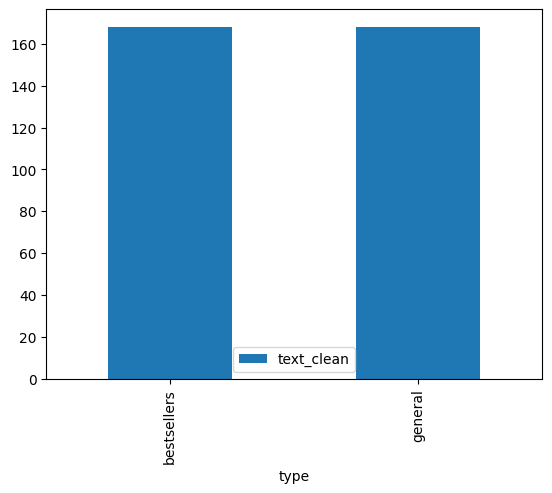

In [70]:
#show sample distribution
bookdescripts[['text_clean','type']].groupby('type').count().plot(kind='bar')

In [71]:
#visualise difference in text after cleaning
print(bookdescripts['text'][0])
print(bookdescripts['text_clean'][0])

The Scarlet Shedder Home Children's Junior Fiction Graphic Novels Dav Pilkey P.U.! Dog Man got sprayed by a skunk! After being dunked in tomato juice, the stink is gone but the scarlet red colour remains. Now exiled, this spunky superhero must struggle to save the citizens who shunned him! Will the ends justify the means for Petey, who's reluctantly pulled back into a life of crime in order to help Dog Man? And who will step forward when an all-new, never-before-seen villain unleashes an army of A.I. robots?
the scarlet shedder home childrens junior fiction graphic novels dav pilkey p u dog man got sprayed by a skunk after being dunked in tomato juice the stink is gone but the scarlet red colour remains now exiled this spunky superhero must struggle to save the citizens who shunned him will the ends justify the means for petey whos reluctantly pulled back into a life of crime in order to help dog man and who will step forward when an all new never before seen villain unleashes an army 

In [79]:
#visualise word frequency
def freq_words(x, terms):
  #collect all words
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #calculate frequency distribution
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top n most frequent words
  d = words_df.nlargest(columns="count", n = terms)

  # visualize words and frequencies
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "count", y = "word", hue = "word")
  ax.set(ylabel = 'Word')
  plt.show()


In [77]:
sns.color_palette("husl", 8)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491)]

In [83]:
#calculate number of unique words
def unique_words(x):
  #collect all words
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  unique_words = list(set(all_words))
  length = len(unique_words)
  return length


In [84]:
unique_words(bookdescripts['text_clean'])

5319

In [88]:
unique_words(bookdescripts[bookdescripts['type']=='bestsellers']['text_clean'])

3370

In [89]:
unique_words(bookdescripts[bookdescripts['type']=='general']['text_clean'])

3203

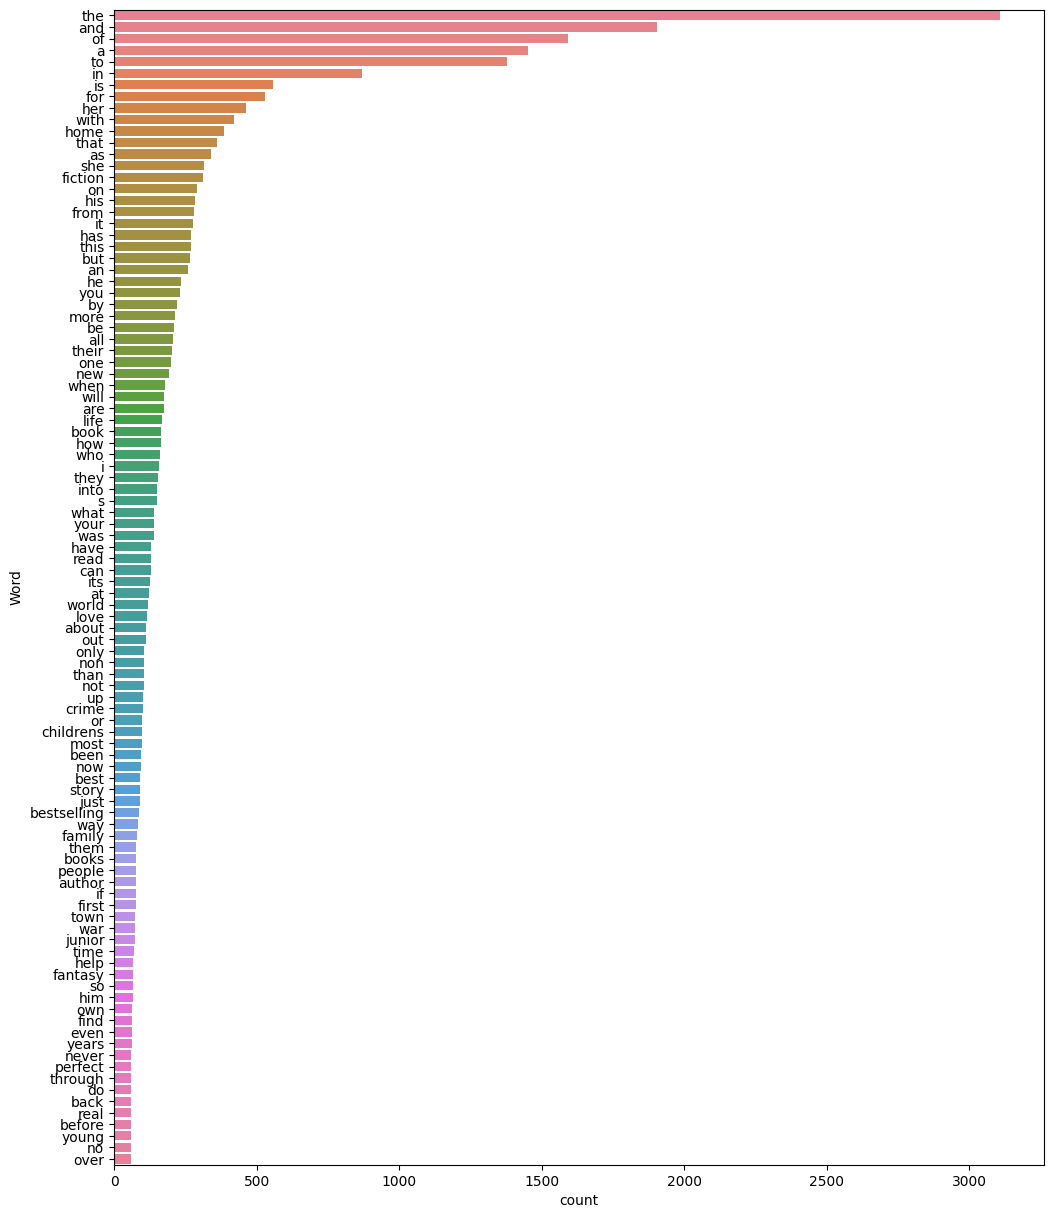

In [80]:
# print 100 most frequent words after cleaning
freq_words(bookdescripts['text_clean'], 100)

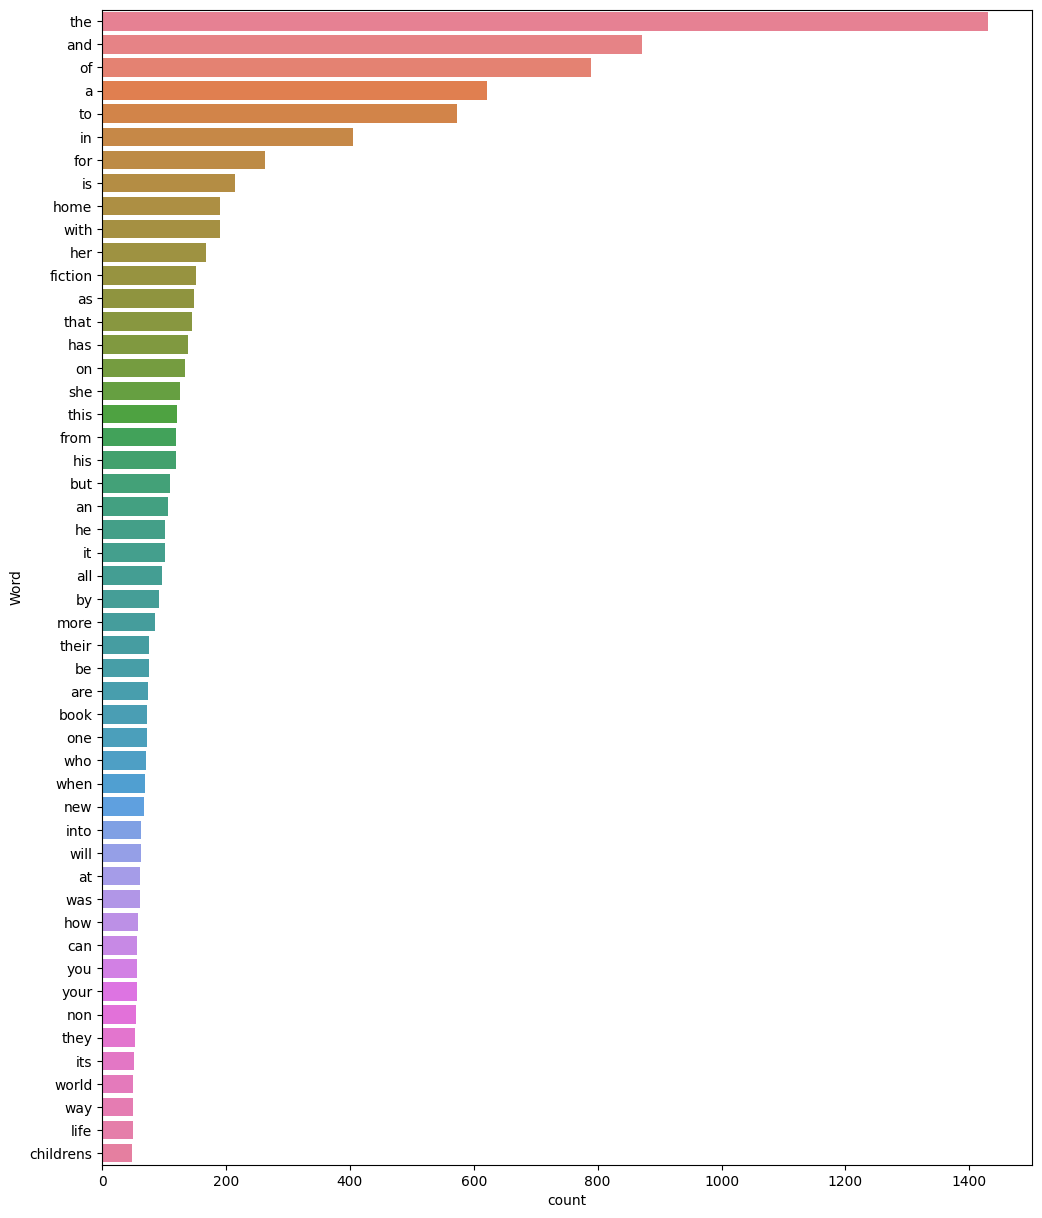

In [90]:
# print 50 most frequent words in general category after cleaning
freq_words(bookdescripts[bookdescripts['type']=='general']['text_clean'], 50)

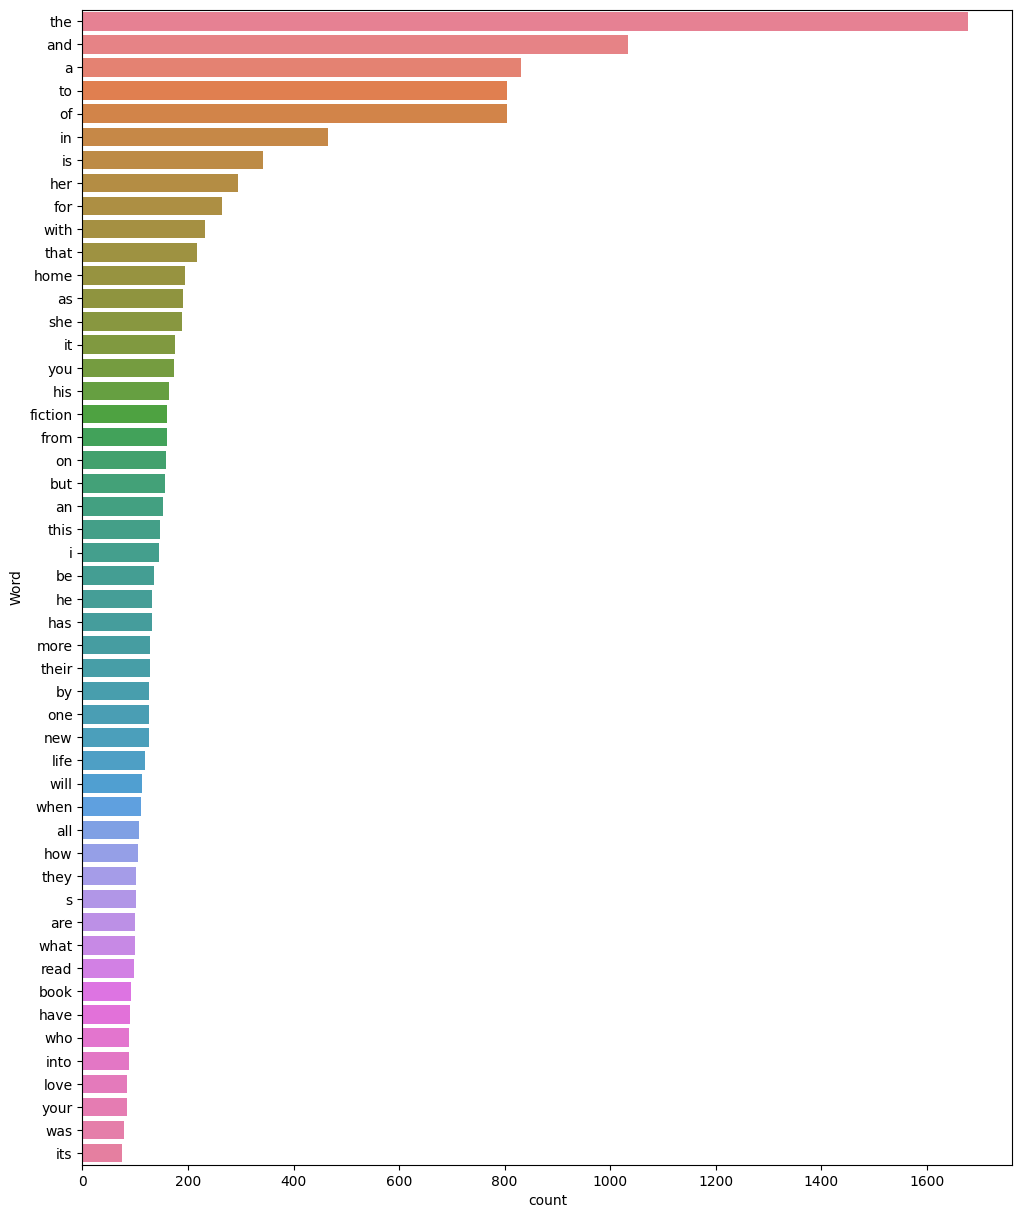

In [92]:
# print 50 most frequent words in bestseller category after cleaning
freq_words(bookdescripts[bookdescripts['type']=='bestsellers']['text_clean'], 50)

In [82]:
#create function to remove stopwords and lemmatize
def remove_stopwords(text):
    text = text.split()
    lem = WordNetLemmatizer()
    #get english stopwords
    all_stopwords = stopwords.words('english')
    #stem all words that aren't stopwords
    text = [lem.lemmatize(word) for word in text if not word in set(all_stopwords)]
    text = ' '.join(text)
    return text

In [95]:
#remove stopwords
bookdescripts['text_stopout'] = bookdescripts['text_clean'].apply(lambda x: remove_stopwords(x))
bookdescripts.head()

,type,title,author,description,text,text_clean,text_stopout
0,bestsellers,The Scarlet Shedder Home Children's Junior Fic...,Dav Pilkey,P.U.! Dog Man got sprayed by a skunk! After be...,The Scarlet Shedder Home Children's Junior Fic...,the scarlet shedder home childrens junior fict...,scarlet shedder home childrens junior fiction ...
1,bestsellers,Powerful (Exclusive Cover) Home Children's You...,Lauren Roberts,From the international bestselling author of P...,Powerful (Exclusive Cover) Home Children's You...,powerful exclusive cover home childrens young ...,powerful exclusive cover home childrens young ...
2,bestsellers,Powerless Home Children's Young Adult,Lauren Roberts,Only the extraordinary belong in the kingdom o...,Powerless Home Children's Young Adult Lauren R...,powerless home childrens young adult lauren ro...,powerless home childrens young adult lauren ro...
3,bestsellers,LGB Taylor Swift Home Children's Junior Non-Fi...,Wendy Loggia,Help your little one dream big with a Little G...,LGB Taylor Swift Home Children's Junior Non-Fi...,lgb taylor swift home childrens junior non fic...,lgb taylor swift home childrens junior non fic...
4,bestsellers,Reckless Home Children's Young Adult,Lauren Roberts,The second heart-racing instalment in this bes...,Reckless Home Children's Young Adult Lauren Ro...,reckless home childrens young adult lauren rob...,reckless home childrens young adult lauren rob...


In [96]:
print(bookdescripts['text_clean'][0])
print(bookdescripts['text_stopout'][0])

the scarlet shedder home childrens junior fiction graphic novels dav pilkey p u dog man got sprayed by a skunk after being dunked in tomato juice the stink is gone but the scarlet red colour remains now exiled this spunky superhero must struggle to save the citizens who shunned him will the ends justify the means for petey whos reluctantly pulled back into a life of crime in order to help dog man and who will step forward when an all new never before seen villain unleashes an army of a i robots
scarlet shedder home childrens junior fiction graphic novel dav pilkey p u dog man got sprayed skunk dunked tomato juice stink gone scarlet red colour remains exiled spunky superhero must struggle save citizen shunned end justify mean petey who reluctantly pulled back life crime order help dog man step forward new never seen villain unleashes army robot


In [97]:
unique_words(bookdescripts['text_stopout'])

4679

In [98]:
unique_words(bookdescripts[bookdescripts['type']=='bestsellers']['text_stopout'])

2967

In [99]:
unique_words(bookdescripts[bookdescripts['type']=='general']['text_stopout'])

2839

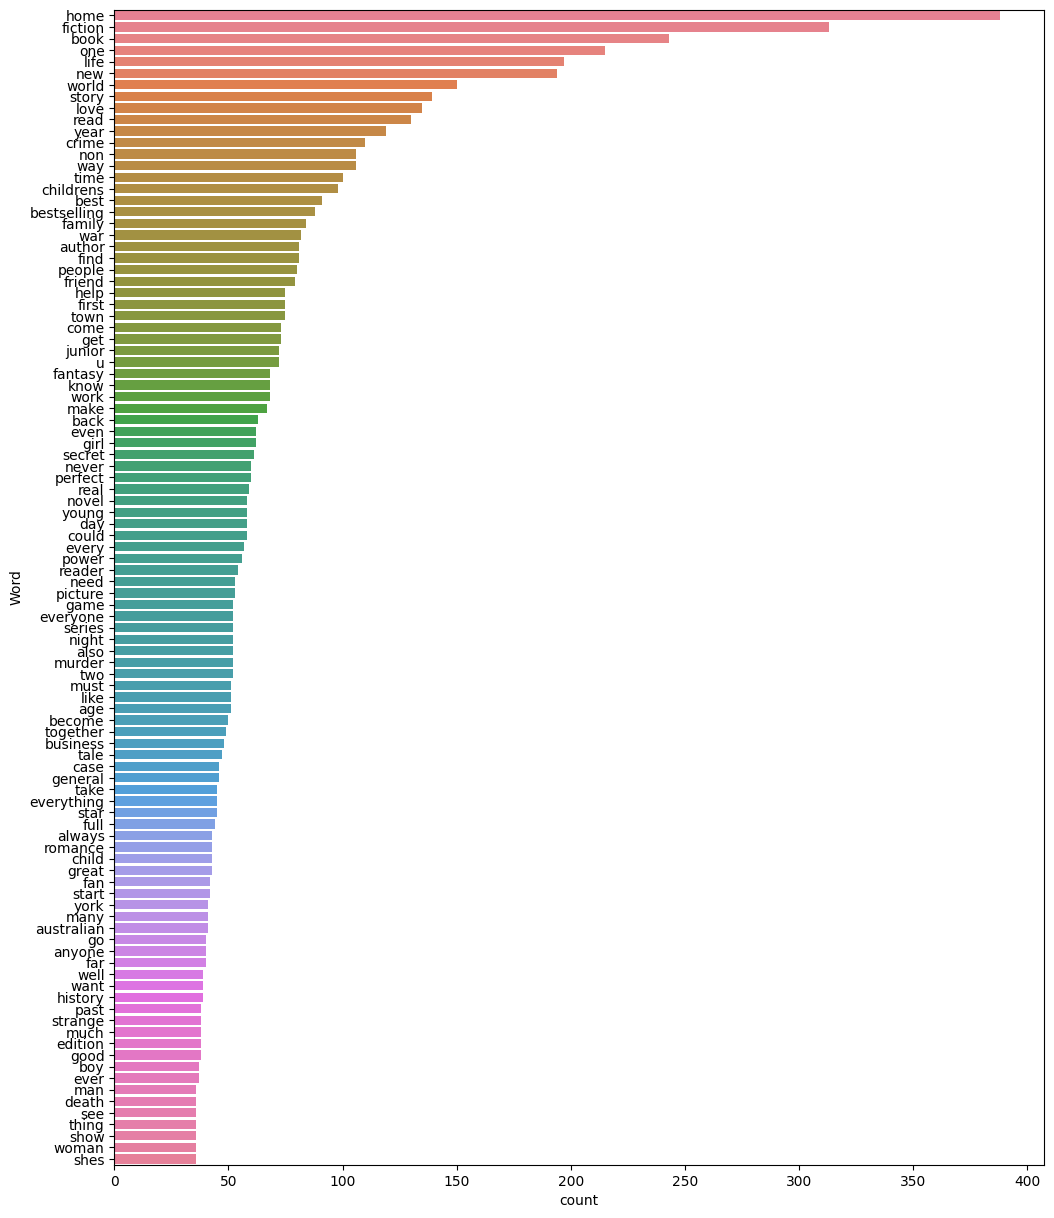

In [100]:
# print 100 most frequent words after removing stopwords and lemmatizing
freq_words(bookdescripts['text_stopout'], 100)

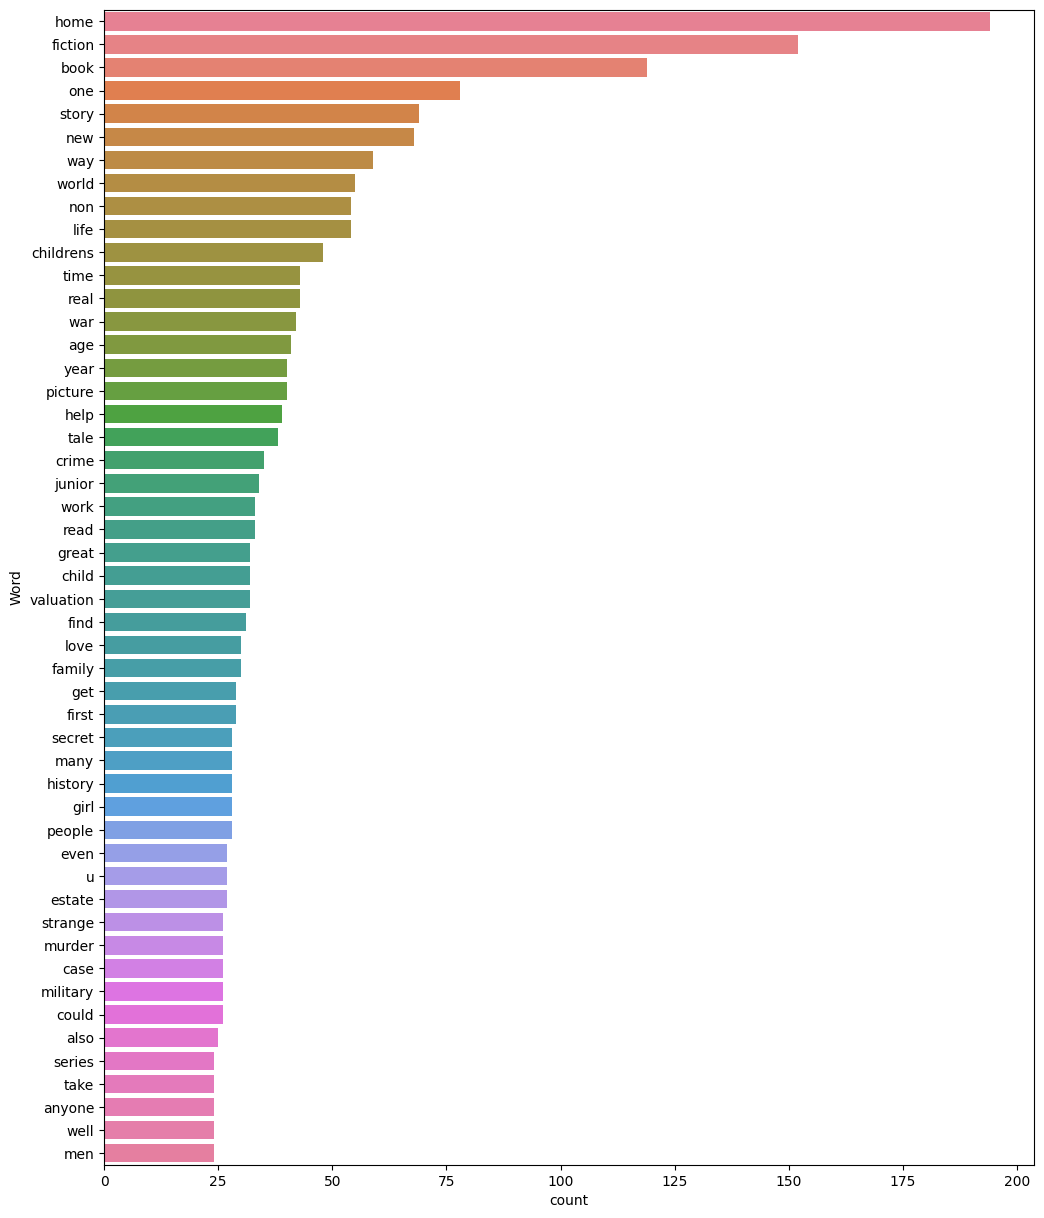

In [101]:
# print 50 most frequent words in general category after removing stopwords and lemmatizing
freq_words(bookdescripts[bookdescripts['type']=='general']['text_stopout'], 50)

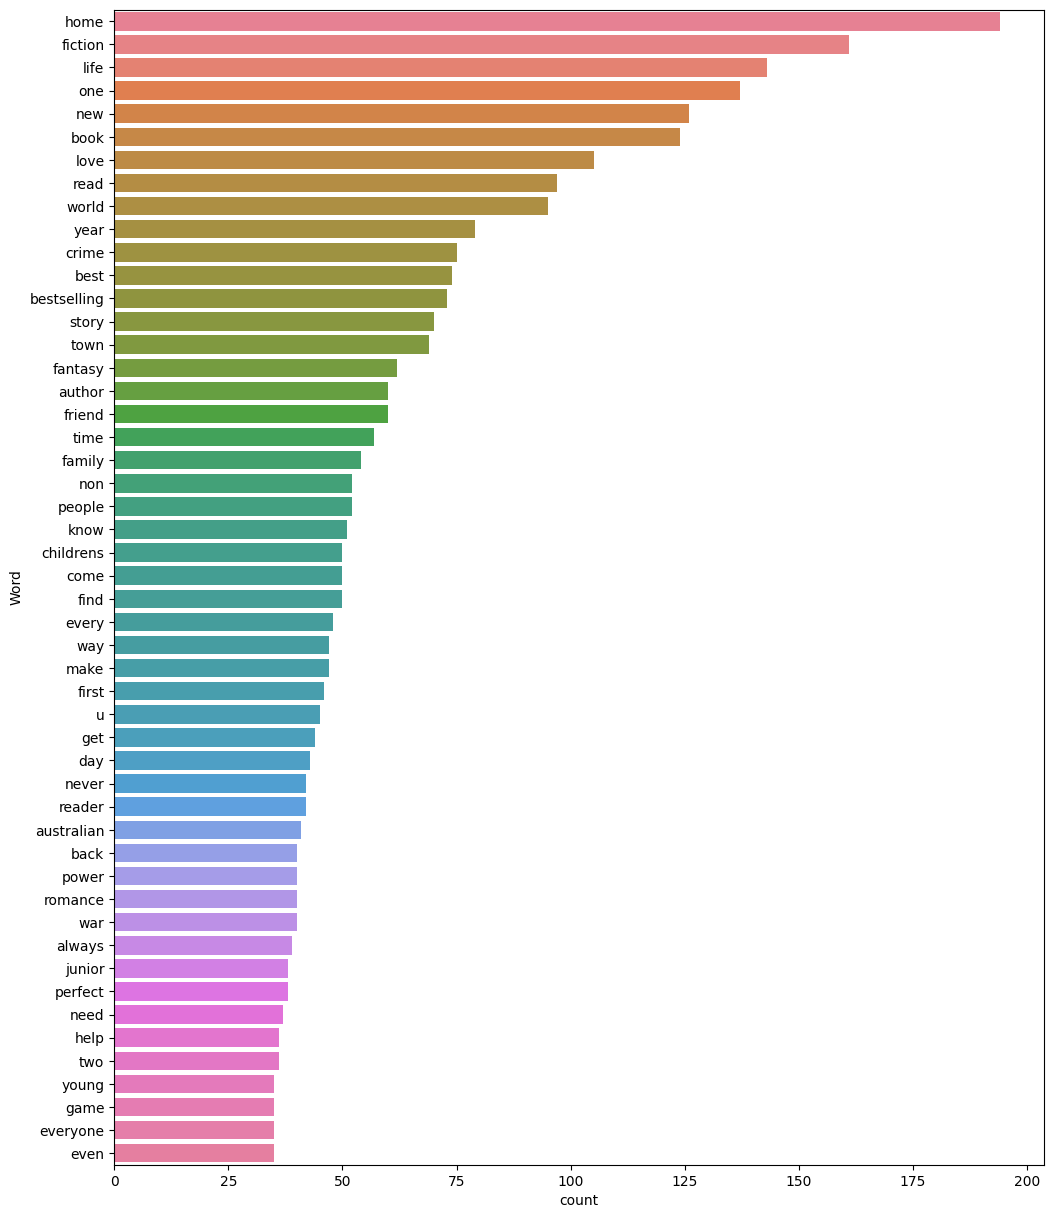

In [102]:
# print 50 most frequent words in bestseller category after removing stopwords and lemmatizing
freq_words(bookdescripts[bookdescripts['type']=='bestsellers']['text_stopout'], 50)

In [110]:
#look for collocations

def coloc(x):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  return nltk.collocations(all_words)



In [119]:
#look for long words
def longwords(x):
  #collect all words
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  all_words = set(all_words)
  long_words = [word for word in all_words if len(word)>13]
  return long_words

In [122]:
longwords(bookdescripts[bookdescripts['type']=='bestsellers']['text_stopout'])

['responsibility',
 'timesmctiernans',
 'unsuspectingly',
 'schwarzenegger',
 'disappointment',
 'internationally',
 'groundbreaking',
 'breathtakingly',
 'rickriordanmythmaster',
 'superficiality',
 'opportunistically',
 'conversationalist',
 'propositioning']

In [126]:
def gethapaxes(x):
  #collect all words
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #calculate frequency distribution
  fdist = nltk.FreqDist(all_words)
  #return hapaxes
  return fdist.hapaxes()

In [131]:
gethapaxes(bookdescripts[bookdescripts['type']=='bestsellers']['text_stopout'])

[]

In [132]:
cleanedcorpus = list(bookdescripts['text_stopout'])

In [133]:
bookdescripts['label'] = np.where(bookdescripts['type']=='bestsellers',1,0)

In [134]:
bookdescripts.head()

,type,title,author,description,text,text_clean,text_stopout,label
0,bestsellers,The Scarlet Shedder Home Children's Junior Fic...,Dav Pilkey,P.U.! Dog Man got sprayed by a skunk! After be...,The Scarlet Shedder Home Children's Junior Fic...,the scarlet shedder home childrens junior fict...,scarlet shedder home childrens junior fiction ...,1
1,bestsellers,Powerful (Exclusive Cover) Home Children's You...,Lauren Roberts,From the international bestselling author of P...,Powerful (Exclusive Cover) Home Children's You...,powerful exclusive cover home childrens young ...,powerful exclusive cover home childrens young ...,1
2,bestsellers,Powerless Home Children's Young Adult,Lauren Roberts,Only the extraordinary belong in the kingdom o...,Powerless Home Children's Young Adult Lauren R...,powerless home childrens young adult lauren ro...,powerless home childrens young adult lauren ro...,1
3,bestsellers,LGB Taylor Swift Home Children's Junior Non-Fi...,Wendy Loggia,Help your little one dream big with a Little G...,LGB Taylor Swift Home Children's Junior Non-Fi...,lgb taylor swift home childrens junior non fic...,lgb taylor swift home childrens junior non fic...,1
4,bestsellers,Reckless Home Children's Young Adult,Lauren Roberts,The second heart-racing instalment in this bes...,Reckless Home Children's Young Adult Lauren Ro...,reckless home childrens young adult lauren rob...,reckless home childrens young adult lauren rob...,1


In [136]:
#use tfidfvectorizer to calculate idf scores for the corpus exluding features that appear in over 95% of the corpus
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, max_features=2000,stop_words='english')
X = tfidf_vectorizer.fit_transform(cleanedcorpus).toarray()
y = bookdescripts['label'].values

In [137]:
print(X)
print(X.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(336, 2000)


In [138]:
features = tfidf_vectorizer.get_feature_names_out()
print(features)
print(len(features))

['aaron' 'ability' 'able' ... 'youve' 'zeus' 'zone']
2000


In [141]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 110)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.25, random_state= 8) # 0.25 x 0.8 = 0.2


print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(y_train.shape))
print("y val shape: {}".format(y_test.shape))

X_train shape: (201, 2000)
X_test shape: (68, 2000)
y_train shape: (201,)
y_test shape: (68,)
X_val shape: (201,)
y val shape: (68,)


In [144]:
# plot the precision-recall curves
def plot_precision_recall(y_test,m_recall,m_precision,classifier_name):
    no_model = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_model, no_model], linestyle='--', label='No Model')
    plt.plot(m_recall, m_precision, marker='.', label=str(classifier_name))
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [145]:
def plot_roc_auc(y_test,probs, classifier):
    nm_probs = [0 for _ in range(len(y_test))]
    # calculate scores
    nm_auc = roc_auc_score(y_test, nm_probs)
    m_auc = roc_auc_score(y_test, probs)
    # summarize scores
    print('No Model: ROC AUC=%.3f' % (nm_auc))
    print('{}: ROC AUC={}'.format('classifier_name',m_auc))
    # calculate roc curves
    nm_fpr, nm_tpr, _ = roc_curve(y_test, nm_probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    # plot the roc curve for the model
    plt.plot(nm_fpr, nm_tpr, linestyle='--', label='No Model')
    plt.plot(fpr, tpr, marker='.', label=str(classifier))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [146]:
def test_classifier(X_train, y_train, X_test, y_test, classifier):
    print("")
    print("******Classification of Restaurant Review ******")
    classifier_name = str(type(classifier).__name__)
    print("Testing " + classifier_name)
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    print("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    print("Predicting time {0}s".format(time() - now))
    # calculate precision and recall for each threshold
    m_precision, m_recall, _ = precision_recall_curve(y_test, probs)
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    print("************ Results ************")
    print("            Negative    Positive")
    print("F1       " + str(f1))
    print("Precision" + str(precision))
    print("Recall   " + str(recall))
    print("Accuracy " + str(accuracy))
    plot_roc_auc(y_test,probs, classifier_name)
    plot_precision_recall(y_test,m_recall,m_precision,classifier_name)
    return precision, recall, accuracy, f1

In [148]:
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=750,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    objective='binary:logistic',
                    nthread=4,
                    seed=2789)


******Classification of Restaurant Review ******
Testing XGBClassifier
Learing time 5.351369142532349s
Predicting time 0.020547151565551758s
************ Results ************
            Negative    Positive
F1       [0.73015873 0.76712329]
Precision[0.74193548 0.75675676]
Recall   [0.71875    0.77777778]
Accuracy 0.75
No Model: ROC AUC=0.500
classifier_name: ROC AUC=0.9114583333333334


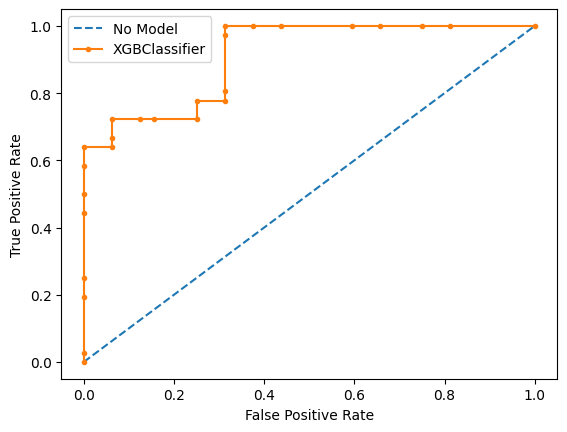

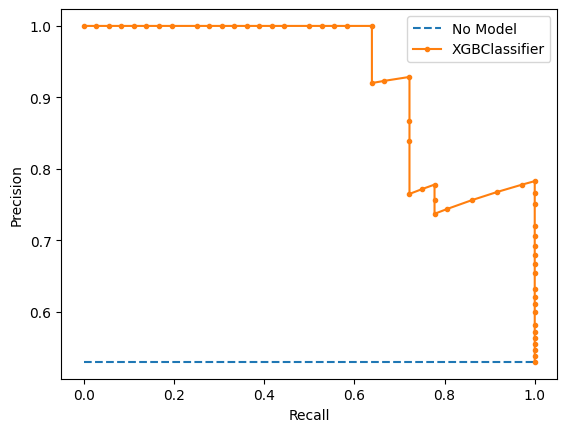

In [149]:
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, xgb1)

In [152]:
preds = xgb1.predict(X_val)
probs = xgb1.predict_proba(X_val)
labels = y_val

In [153]:
print(confusion_matrix(labels, preds))
print(accuracy_score(labels, preds))
print(recall_score(labels, preds))
print(precision_score(labels, preds))

[[32  3]
 [ 5 27]]
0.8805970149253731
0.84375
0.9


In [154]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

In [156]:
param_test1 = {
 'max_depth':range(1,8,2),
 'min_child_weight':range(1,8,2)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='roc_auc',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=750,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 8, 2),
                         'min_child_weight': range(1, 8, 2)},
             scoring='roc_auc', verbose=10)

In [157]:
getTrainScores(gsearch1)

({0: "mean:0.9175476190476191params{'max_depth': 1, 'min_child_weight': 1}",
  1: "mean:0.8525params{'max_depth': 1, 'min_child_weight': 3}",
  2: "mean:0.8006190476190476params{'max_depth': 1, 'min_child_weight': 5}",
  3: "mean:0.7583809523809524params{'max_depth': 1, 'min_child_weight': 7}",
  4: "mean:0.9388333333333334params{'max_depth': 3, 'min_child_weight': 1}",
  5: "mean:0.9215714285714286params{'max_depth': 3, 'min_child_weight': 3}",
  6: "mean:0.8590714285714285params{'max_depth': 3, 'min_child_weight': 5}",
  7: "mean:0.7979285714285715params{'max_depth': 3, 'min_child_weight': 7}",
  8: "mean:0.9392619047619049params{'max_depth': 5, 'min_child_weight': 1}",
  9: "mean:0.9144285714285714params{'max_depth': 5, 'min_child_weight': 3}",
  10: "mean:0.859595238095238params{'max_depth': 5, 'min_child_weight': 5}",
  11: "mean:0.7979285714285715params{'max_depth': 5, 'min_child_weight': 7}",
  12: "mean:0.9456428571428571params{'max_depth': 7, 'min_child_weight': 1}",
  13: "me

In [159]:
xgb2 = XGBClassifier(learning_rate=0.1,
                    n_estimators=750,
                    max_depth=7,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    objective='binary:logistic',
                    nthread=4,
                    seed=2789)


******Classification of Restaurant Review ******
Testing XGBClassifier
Learing time 3.5427849292755127s
Predicting time 0.010335922241210938s
************ Results ************
            Negative    Positive
F1       [0.73015873 0.76712329]
Precision[0.74193548 0.75675676]
Recall   [0.71875    0.77777778]
Accuracy 0.75
No Model: ROC AUC=0.500
classifier_name: ROC AUC=0.9105902777777778


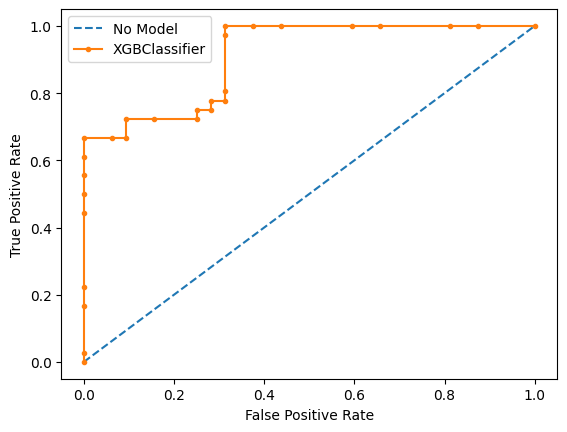

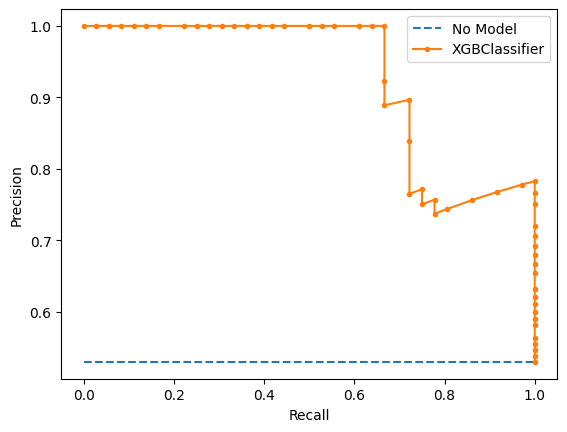

In [160]:
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, xgb2)

In [163]:
preds = xgb2.predict(X_test)
probs = xgb2.predict_proba(X_test)
labels = y_test

In [164]:
print(confusion_matrix(labels, preds))
print(accuracy_score(labels, preds))
print(recall_score(labels, preds))
print(precision_score(labels, preds))

[[23  9]
 [ 8 28]]
0.75
0.7777777777777778
0.7567567567567568



******Classification of Restaurant Review ******
Testing LogisticRegression
Learing time 0.027680635452270508s
Predicting time 0.001260995864868164s
************ Results ************
            Negative    Positive
F1       [0.8125     0.83333333]
Precision[0.8125     0.83333333]
Recall   [0.8125     0.83333333]
Accuracy 0.8235294117647058
No Model: ROC AUC=0.500
classifier_name: ROC AUC=0.9513888888888888


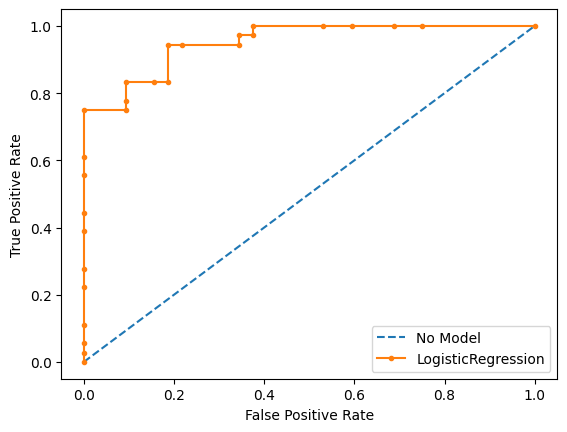

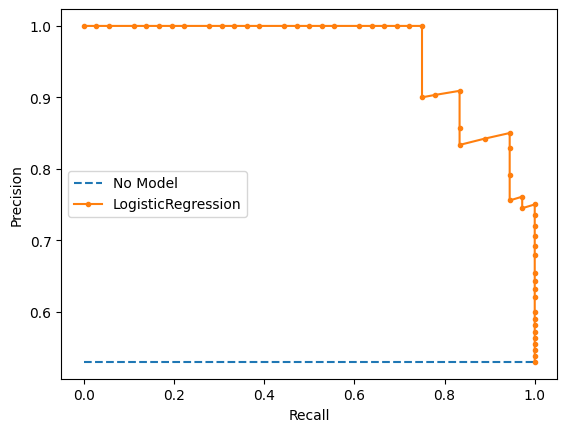

In [166]:
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, LogisticRegression(random_state=0))


******Classification of Restaurant Review ******
Testing KNeighborsClassifier
Learing time 0.010778427124023438s
Predicting time 0.05187177658081055s
************ Results ************
            Negative    Positive
F1       [0.67692308 0.70422535]
Precision[0.66666667 0.71428571]
Recall   [0.6875     0.69444444]
Accuracy 0.6911764705882353
No Model: ROC AUC=0.500
classifier_name: ROC AUC=0.8142361111111112


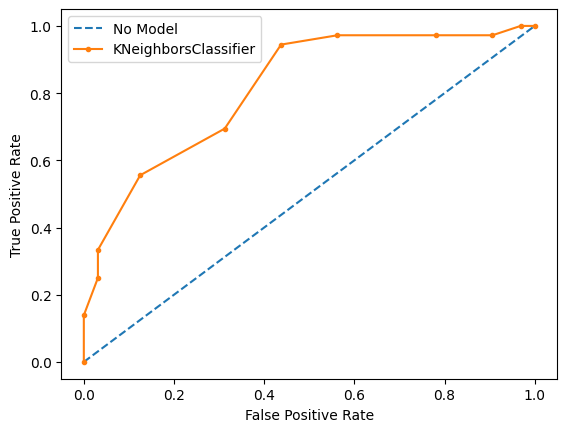

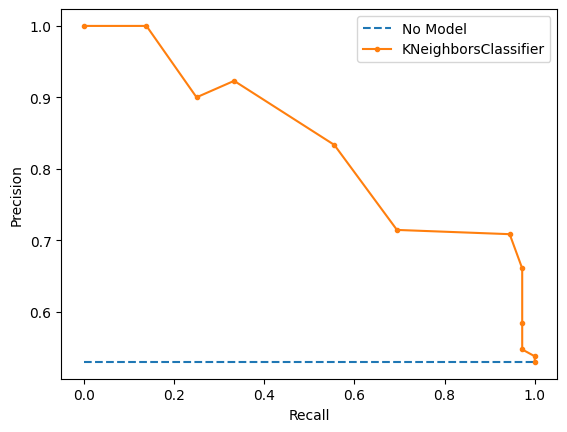

In [169]:
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, KNeighborsClassifier(n_neighbors=10))


******Classification of Restaurant Review ******
Testing RandomForestClassifier
Learing time 0.16606926918029785s
Predicting time 0.016129493713378906s
************ Results ************
            Negative    Positive
F1       [0.83333333 0.8125    ]
Precision[0.75       0.92857143]
Recall   [0.9375     0.72222222]
Accuracy 0.8235294117647058
No Model: ROC AUC=0.500
classifier_name: ROC AUC=0.9131944444444444


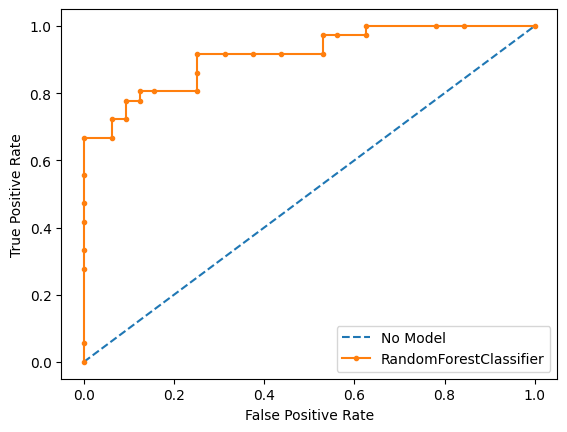

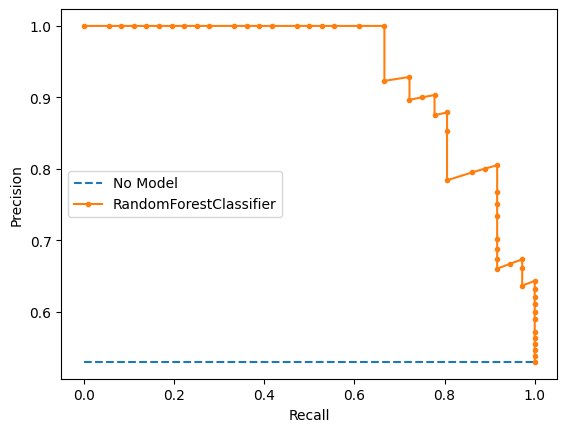

In [168]:
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, RandomForestClassifier(max_depth=2, random_state=0))